In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import re
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Get list of names from data
data = pd.read_csv('../data/companies_sorted.csv')
names = data['name'].tolist()

In [3]:
# Cut data to first million names to reduce training time - not looking for the most accurate anyway.
names = names[:1000000]

In [4]:
len(names)

1000000

In [5]:
# Build the vocabulary of characters and index mapping - to and from integers
# Involves making sure all the names are strings (as some are floats) and removing any names with non-alphanumeric characters
# (as some of these companies are from other countries and have non-English characters in their names).
# Maybe we should limit to US and UK companies only as the names are likely to be more similar and contain English words - extension.
names = [str(name) for name in names]
pattern = re.compile(r'^[a-zA-Z\d]+$')
filtered_names = [name for name in names if pattern.match(name)]
chars = sorted(list(set(''.join(filtered_names))))

In [6]:
len(chars)

36

In [7]:
stoi = {char: i+1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos = {i: char for char, i in stoi.items()}

In [8]:
assert len(stoi) == len(chars) + 1, "Error: Vocabulary size does not match character set size"
assert len(stoi) == len(itos), "Error: Indexes to characters and characters to indexes do not match"

In [9]:
# Create x and y datasets from list of company names.
# I want two lists of lists, one for x and one for y
# x contain the first x letters of each name, each letter will be its own element of a list
# y contains the next letter
block_size = 3
X, Y = [], []
for name in filtered_names:
    # print(name)
    context = [0] * block_size
    for char in name + '.':
        ix = stoi[char]
        X.append(context)
        Y.append(ix)
        # print(''.join([itos[i] for i in context]), '-->', char)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)


In [10]:
# Create the embeddings for the characters.
# The embeddings will be a feature vector of length 10 for each character.
# The table of embeddings will be a matrix of size (vocab_size, embedding_size).

embedding_size = 10
vocab_size = len(stoi)

# Createa randn tensor of size (vocab_size, embedding_size) as the embeddings lookup table.
C = torch.randn(vocab_size, embedding_size)
# Apply these embeddings to the input data by using pytorch indexing.
embeddings = C[X]
embeddings.shape

torch.Size([1116580, 3, 10])

In [11]:
# Creating the first hidden layer.
# The input of this layer will be each of the characters in the context, input as their feature vectors (embeddings),
# the block_size (3) * embedding_size (10) = 30.
# The bias will be a vector of size 50, as the hidden layer has 50 outputs.
# In the paper, the hidden layer either has 0, 50, or 100 outputs.
# To get the activations of the hidden layer, we matrix multiply the inputs by the weights and add the bias, and 
# then apply the tanh activation function.

hidden_size = 50

W1 = torch.randn(block_size * embedding_size, hidden_size)
b1 = torch.randn(hidden_size)

h = torch.tanh(embeddings.view(-1, block_size * embedding_size) @ W1 + b1)

In [12]:
h.shape

torch.Size([1116580, 50])

In [13]:
# Create the output layer, which will take an input size of the output from the hidden layer (50)
# and output a vector of size vocab_size (37).
# With these numbers, we then need to normalise them, so we exponentiate them and divide by the sum of the exponentiated values.
# This gives us the probabilities of each character being the next character in the sequence.

W2 = torch.randn(hidden_size, vocab_size)
b2 = torch.randn(vocab_size)

logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [14]:
# Calculate the loss of the model.
# The loss is the negative log likelihood of the correct character.
# We need to find the next character (Y), and look at the probability the model gives of the actual next character being
# the predicted next character by the model.

loss = -prob[torch.arange(len(Y)), Y].log().mean()
loss

tensor(15.0957)

## Refactored

In [15]:
X.shape, Y.shape

(torch.Size([1116580, 3]), torch.Size([1116580]))

In [16]:
g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, embedding_size), generator=g, requires_grad=True)
W1 = torch.randn((block_size * embedding_size, hidden_size), generator=g, requires_grad=True)
b1 = torch.randn(hidden_size, generator=g, requires_grad=True)
W2 = torch.randn((hidden_size, vocab_size), generator=g, requires_grad=True)
b2 = torch.randn(vocab_size, generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [17]:
sum(p.nelement() for p in parameters)

3807

## Training Loop

In [18]:
lossi = []
stepi = []

training_steps = 100000

# Forward pass
for i in range(training_steps):
    stepi.append(i)

    # Mini batch
    ix = torch.randint(0, X.shape[0], (32,))

    # Forward pass
    embeddings = C[X[ix]]
    h = torch.tanh(embeddings.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    lossi.append(loss.item())

    if i % 10000 == 0:
        print(f'{i}/{training_steps} --> {loss.item()}')

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    for p in parameters:
        p.data += -0.1 * p.grad

0/100000 --> 14.354634284973145
10000/100000 --> 2.825610399246216
20000/100000 --> 2.5554866790771484
30000/100000 --> 2.765424966812134
40000/100000 --> 2.8255910873413086
50000/100000 --> 2.4587152004241943
60000/100000 --> 3.024714231491089
70000/100000 --> 2.570897340774536
80000/100000 --> 2.698364496231079
90000/100000 --> 2.6044254302978516


In [19]:
loss

tensor(2.3727, grad_fn=<NllLossBackward0>)

## Refactored

In [20]:
def get_names(names, block_size=3):
    X, Y = [], []
    for name in names:
        context = [0] * block_size
        for char in name + '.':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(filtered_names)
n1 = int(len(filtered_names) * 0.8)
n2 = int(len(filtered_names) * 0.9)

Xtr, Ytr = get_names(filtered_names[:n1])
Xdev, Ydev = get_names(filtered_names[n1:n2])
Xte, Yte = get_names(filtered_names[n2:])

torch.Size([893291, 3]) torch.Size([893291])
torch.Size([111649, 3]) torch.Size([111649])
torch.Size([111640, 3]) torch.Size([111640])


In [21]:
embedding_size = 10
vocab_size = len(stoi)
hidden_size = 100

In [22]:
g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, embedding_size), generator=g)
W1 = torch.randn((block_size * embedding_size, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters)

7207

In [23]:
for p in parameters:
    p.requires_grad= True

In [24]:
lossi = []
stepi = []

training_steps = 200000

# Forward pass
for i in range(training_steps):

    # Mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward pass
    embeddings = C[Xtr[ix]]
    h = torch.tanh(embeddings.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    if i % 10000 == 0:
        print(f'{i}/{training_steps} --> {loss.item()}')

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    stepi.append(i)
    lossi.append(loss.item())

0/200000 --> 3.6374733448028564
10000/200000 --> 2.569020986557007
20000/200000 --> 2.2896862030029297
30000/200000 --> 2.376497268676758
40000/200000 --> 3.0814387798309326
50000/200000 --> 2.586749315261841
60000/200000 --> 2.406029224395752
70000/200000 --> 2.8085811138153076
80000/200000 --> 2.670215368270874
90000/200000 --> 2.706423759460449
100000/200000 --> 2.5788636207580566
110000/200000 --> 2.4807052612304688
120000/200000 --> 2.1088316440582275
130000/200000 --> 2.4689979553222656
140000/200000 --> 2.5768625736236572
150000/200000 --> 2.7530150413513184
160000/200000 --> 2.451753616333008
170000/200000 --> 2.334465503692627
180000/200000 --> 2.272862195968628
190000/200000 --> 2.2476892471313477


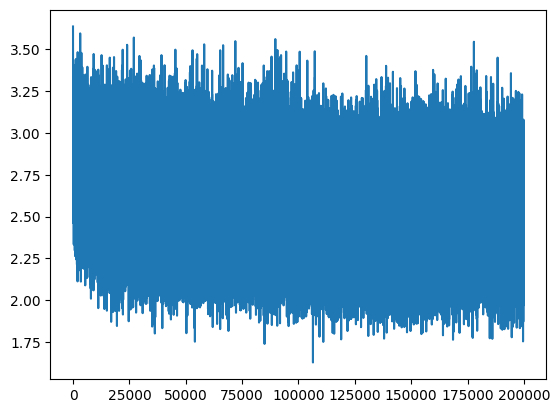

In [25]:
plt.plot(stepi, lossi)

In [26]:
@torch.no_grad()
def calc_loss(x, y):
    embeddings = C[x]
    h = torch.tanh(embeddings.view(-1, block_size * embedding_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(loss.item())

calc_loss(Xtr, Ytr)
calc_loss(Xdev, Ydev)

2.4923901557922363
2.4968950748443604


embeddings=10 <br>
hidden_size=50 <br>
training=? <br>
train = 2.5987 <br>
dev = 2.5998 <br>
<br>
embeddings=10 <br>
hidden_size=100 <br>
training=200,000 <br>
train = 2.5544 <br>
dev = 2.5546 <br>
<br>
Squashing down the output weights <br>
embeddings=10 <br>
hidden_size=100 <br>
training=200,000 <br>
train = 2.4937 <br>
dev = 2.4998 <br>
<br>
Add in direct connection between embeddings and output layer <br>
embeddings=10 <br>
hidden_size=100 (+30 for embeddings)<br>
training=200,000 <br>
train = 2.4858 <br>
dev = 2.4893 <br>
<br>
Add in direct connection between embeddings and output layer <br>
embeddings=10 <br>
hidden_size=100 (+30 for embeddings)<br>
training=300,000 <br>
train = 2.4722 <br>
dev = 2.4787 <br>

## Sampling from the Model

In [27]:
g_sample = torch.Generator().manual_seed(420)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        embeddings = C[torch.tensor([context])]
        h = torch.tanh(embeddings.view(-1, block_size * embedding_size) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs[0], 1, generator=g_sample).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join([itos[i] for i in out]))

hyrosimp.
sir.
dis.
brigia.
fline.
devica.
stilansberevist.
clm.
crigel.
infaq.
lesenofestrek.
kndoision.
mindymberr.
hetegranoct.
hometrrylihmapioke.
nevance.
aquperianssbavemidon.
i.
ga2a.
neormacio.


## Direct Connection between Input and Output

In [28]:
g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, embedding_size), generator=g)
W1 = torch.randn((block_size * embedding_size, hidden_size), generator=g)
b1 = torch.randn((hidden_size), generator=g)
W2 = torch.randn((hidden_size + block_size * embedding_size, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size), generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [29]:
sum(p.nelement() for p in parameters)

8317

In [30]:
lossi = []
stepi = []

training_steps = 300000

for i in range(training_steps):

    # Mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # Forward pass
    embeddings = C[Xtr[ix]]
    h_temp = torch.tanh(embeddings.view(-1, block_size * embedding_size) @ W1 + b1)
    h = torch.cat((h_temp, embeddings.view(-1, block_size * embedding_size)), dim=1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    if i % 10000 == 0:
        print(f'{i}/{training_steps} --> {loss.item()}')

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    lossi.append(loss.item())
    stepi.append(i)

0/300000 --> 3.6651499271392822
10000/300000 --> 2.7665839195251465
20000/300000 --> 2.6561546325683594
30000/300000 --> 2.8049159049987793
40000/300000 --> 2.5437724590301514
50000/300000 --> 2.3817715644836426
60000/300000 --> 2.627906322479248
70000/300000 --> 2.6886346340179443
80000/300000 --> 2.3847267627716064
90000/300000 --> 2.5476043224334717
100000/300000 --> 2.474571704864502
110000/300000 --> 2.551469564437866
120000/300000 --> 2.498542070388794
130000/300000 --> 2.459550380706787
140000/300000 --> 2.348637104034424
150000/300000 --> 2.4519827365875244
160000/300000 --> 2.306771993637085
170000/300000 --> 2.370269536972046
180000/300000 --> 2.476262331008911
190000/300000 --> 2.626415252685547
200000/300000 --> 2.7846217155456543
210000/300000 --> 2.1786723136901855
220000/300000 --> 2.4667959213256836
230000/300000 --> 2.3595457077026367
240000/300000 --> 2.6639316082000732
250000/300000 --> 2.459690809249878
260000/300000 --> 2.5044806003570557
270000/300000 --> 2.766547

In [31]:
@torch.no_grad()
def calc_loss(x, y):
    embeddings = C[x]
    h_temp = torch.tanh(embeddings.view(-1, block_size * embedding_size) @ W1 + b1)
    h = torch.cat((h_temp, embeddings.view(-1, block_size * embedding_size)), dim=1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(loss.item())

calc_loss(Xtr, Ytr)
calc_loss(Xdev, Ydev)

2.4722280502319336
2.4787826538085938


In [32]:
g_sample = torch.Generator().manual_seed(420)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        embeddings = C[torch.tensor([context])]
        h_temp = torch.tanh(embeddings.view(-1, block_size * embedding_size) @ W1 + b1)
        h = torch.cat((h_temp, embeddings.view(-1, embedding_size * block_size)), dim=1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs[0], 1, generator=g_sample).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join([itos[i] for i in out]))

hyrosemrish.
sims.
brigia.
flintech.
mco.
starawsb.
auvist.
clm.
cradel.
vipaq.
lenetoffertek.
knpoinworkm.
edymartreheelarkale.
feon.
greylismario.
wenengoch.
aquamoweassbarsmartele.
ga2deatiemacizen.
beon.
jprushodm.
